In [ ]:
from google.colab import drive
import zipfile
import os

MOUNT_DIR = '/content/drive'
DATA_DIR_SMALLER = '/content/drive/MyDrive/DatasetSmaller.zip'
EXTRACTED_DIR = '/content/dataFolder'

# Mount Google Drive
drive.mount(MOUNT_DIR, force_remount=False)

# Path to the zip file in your Google Drive
zip_file_path = DATA_DIR_SMALLER

# Directory to extract the contents
extracted_dir_path = EXTRACTED_DIR


def extract_data(extracted_dir_path):
  # Extract the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extracted_dir_path)

extract_data(extracted_dir_path)

Mounted at /content/drive


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils import data

# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# You could add your own libraries from Python Standard Library in this cell. Any other external libraries are not allowed.
import os

In [ ]:
class ChestDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs


    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # print("Image size before transformation:", image.size)

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        # print("Image size after transformation:", image.shape)

        return image, label

def get_dataset(root):
    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((299, 299
                        )),
        transforms.ToTensor(),
    ])

    # Load datasets for training, validation, and test with size (224, 224)
    dataset = ChestDataset(path=root, transform=transform)

    # Compute mean and std for normalization
    def compute_mean_and_std(dataset):
        mean_sum = np.zeros(3)
        std_sum = np.zeros(3)
        num_samples = len(dataset)

        for img, _ in dataset:
            img = np.array(img)
            # Compute mean along height and width axes
            img_mean = np.mean(img, axis=(1, 2))
            # Compute std along height and width axes
            img_std = np.std(img, axis=(1, 2))

            mean_sum += img_mean
            std_sum += img_std

        # Compute overall mean and std across all images
        mean = mean_sum / num_samples
        std = std_sum / num_samples

        return mean, std

    train_mean, train_std = compute_mean_and_std(dataset)

    # Apply normalization with computed mean and std
    transform = transforms.Compose([
        transform,
        transforms.Normalize(mean=train_mean, std=train_std)
    ])

    # Apply normalization to datasets
    dataset.transform = transform

    return dataset

In [ ]:
def get_loaders(data_foldername, train_batch = 64, test_batch = 64, val_batch = 64):
    # Create the full dataset
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dataset = get_dataset(dataset_path)

    # Assume each data point is a tuple (image, label) and collect the labels
    labels = [label for _, label in dataset]

    # Generate indices: full range of dataset
    full_indices = list(range(len(dataset)))

    # First split: separate out the test set
    train_val_indices, test_indices = train_test_split(
    full_indices, test_size=0.1, stratify=labels, random_state=42
    )

    # Adjust the labels and indices for the next split by filtering out test indices
    train_val_labels = [labels[i] for i in train_val_indices]

    # Second split: split the remaining data into train and validation sets
    train_indices, val_indices = train_test_split(
    train_val_indices, test_size=(0.1 / 0.9), stratify=train_val_labels, random_state=42
    )

    # Create subsets for train, validation, and test
    train_dataset = data.Subset(dataset, train_indices)
    val_dataset = data.Subset(dataset, val_indices)
    test_dataset = data.Subset(dataset, test_indices)

    # Create dataset loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch)
    val_loader = DataLoader(dataset=val_dataset, batch_size=val_batch)

    return train_loader, test_loader, val_loader

def get_num_of_classes(data_foldername):
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dummy_dataset = ChestDataset(path=dataset_path)
    num_of_classes = len(dummy_dataset.data.classes)

    return num_of_classes

def train_for_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

def validate_for_epoch(model, val_loader, loss_fn, device):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return val_loss / len(val_loader), accuracy

def train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path):
    best_val_loss = float('inf')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(max_epoch):
        # Training
        train_loss, train_accuracy = train_for_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # Corrected variable name

        # Validation
        val_loss, val_accuracy = validate_for_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{max_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save best model according to validation performance
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)


    history = {'train_losses': train_losses, 'train_accuracies': train_accuracies, 'val_losses': val_losses, 'val_accuracies': val_accuracies}

    return history

def plot_losses(history):
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses vs Epoch')
    plt.legend()
    plt.show()

def plot_accuracies(history):
    plt.plot(history['train_accuracies'], label='Train Accuracy')
    plt.plot(history['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

def load_best_model(model_path):
    state_dict = torch.load(model_path)
    # Instantiate your model
    model = CNN()
    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def load_best_model_transfer(model_path, data_foldername):
    state_dict = torch.load(model_path)

    # Instantiate your model
    model = models.inception_v3(pretrained=False)

    # Get the number of input features to the fully connected layer
    num_features = model.fc.in_features

    # Get the number of classes from the dataset
    num_classes = get_num_of_classes(data_foldername)

    # Replace the fully connected layer with a new one
    model.fc = nn.Sequential(
        nn.Linear(num_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),  # Add dropout with 20% probability
        nn.Linear(1024, num_classes)
    ).to(device)

    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def test_model(model, test_loader, device):
    model.eval()
    loss_func = nn.CrossEntropyLoss()

    all_predictions = []
    all_targets = []
    all_losses = []
    all_probs = [] # for roc-auc

    # Move model to device
    model.to(device)

    # Disable gradients for evaluation
    with torch.no_grad():
        for images, targets in test_loader:
            # Move images and targets to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(images)
            # Compute loss
            loss = loss_func(outputs, targets)
            all_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Get probabilities
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(outputs)
            all_probs.extend(probs.cpu().numpy())

    # Convert targets and predictions to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    return all_losses, all_predictions, all_targets, all_probs

def calculate_metrics(all_losses, all_predictions, all_targets):
    # Calculate evaluation metrics
    mean_loss = np.mean(all_losses)
    acc = accuracy_score(all_targets, all_predictions)
    pre = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Return metric results as a dictionary
    metrics = {
        'mean_loss': mean_loss,
        'accuracy': acc,
        'precision': pre,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

def plot_confusion_matrix(conf_matrix, classes):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_auc(targets, probs, class_names):
    num_classes = probs.shape[1]
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        # Create binary target for the current class
        binary_targets = np.array(targets == i, dtype=int)
        fpr, tpr, _ = roc_curve(binary_targets, probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve ({}) (AUC = {:.2f})'.format(class_names[i], roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Load datasets for training, validation, and test with size (224, 224)
dataset = ChestDataset(path="dataFolder/folder")

# Access the classes attribute to get the class names
class_names = dataset.data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Epoch 1/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/30], Train Loss: 1.7546, Val Loss: 1.6352, Train Acc: 0.2188, Val Acc: 0.3000


Epoch 2/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/30], Train Loss: 1.5739, Val Loss: 1.6094, Train Acc: 0.3013, Val Acc: 0.2700


Epoch 3/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/30], Train Loss: 1.5400, Val Loss: 1.6311, Train Acc: 0.3162, Val Acc: 0.2900


Epoch 4/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/30], Train Loss: 1.5323, Val Loss: 1.5867, Train Acc: 0.3137, Val Acc: 0.2500


Epoch 5/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/30], Train Loss: 1.5187, Val Loss: 1.5795, Train Acc: 0.3262, Val Acc: 0.3300


Epoch 6/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/30], Train Loss: 1.4637, Val Loss: 3.3248, Train Acc: 0.3588, Val Acc: 0.1700


Epoch 7/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/30], Train Loss: 1.4961, Val Loss: 1.5338, Train Acc: 0.3700, Val Acc: 0.3000


Epoch 8/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/30], Train Loss: 1.4309, Val Loss: 1.7464, Train Acc: 0.4000, Val Acc: 0.2100


Epoch 9/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/30], Train Loss: 1.4568, Val Loss: 1.6338, Train Acc: 0.3725, Val Acc: 0.2800


Epoch 10/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 10/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/30], Train Loss: 1.4910, Val Loss: 1.6324, Train Acc: 0.3488, Val Acc: 0.3000


Epoch 11/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 11/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/30], Train Loss: 1.4619, Val Loss: 1.5592, Train Acc: 0.3787, Val Acc: 0.3000


Epoch 12/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 12/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/30], Train Loss: 1.4583, Val Loss: 1.8929, Train Acc: 0.3538, Val Acc: 0.3000


Epoch 13/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 13/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/30], Train Loss: 1.4240, Val Loss: 1.5131, Train Acc: 0.3937, Val Acc: 0.4100


Epoch 14/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 14/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/30], Train Loss: 1.4462, Val Loss: 1.6028, Train Acc: 0.4025, Val Acc: 0.2900


Epoch 15/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 15/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/30], Train Loss: 1.4006, Val Loss: 1.5553, Train Acc: 0.4000, Val Acc: 0.3200


Epoch 16/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 16/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/30], Train Loss: 1.4018, Val Loss: 1.5054, Train Acc: 0.4037, Val Acc: 0.2700


Epoch 17/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 17/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/30], Train Loss: 1.3951, Val Loss: 1.8231, Train Acc: 0.4363, Val Acc: 0.2200


Epoch 18/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 18/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/30], Train Loss: 1.3643, Val Loss: 1.8414, Train Acc: 0.4400, Val Acc: 0.2300


Epoch 19/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 19/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/30], Train Loss: 1.3705, Val Loss: 2.0241, Train Acc: 0.4363, Val Acc: 0.3000


Epoch 20/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 20/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/30], Train Loss: 1.3780, Val Loss: 1.8221, Train Acc: 0.4275, Val Acc: 0.3000


Epoch 21/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 21/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/30], Train Loss: 1.3702, Val Loss: 1.7636, Train Acc: 0.4250, Val Acc: 0.2900


Epoch 22/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 22/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/30], Train Loss: 1.3107, Val Loss: 1.7213, Train Acc: 0.4625, Val Acc: 0.3200


Epoch 23/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 23/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/30], Train Loss: 1.2989, Val Loss: 1.7343, Train Acc: 0.4875, Val Acc: 0.2500


Epoch 24/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 24/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/30], Train Loss: 1.3137, Val Loss: 1.6691, Train Acc: 0.4600, Val Acc: 0.2500


Epoch 25/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 25/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/30], Train Loss: 1.2718, Val Loss: 1.6499, Train Acc: 0.4863, Val Acc: 0.2800


Epoch 26/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 26/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/30], Train Loss: 1.2779, Val Loss: 1.6334, Train Acc: 0.4875, Val Acc: 0.3000


Epoch 27/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 27/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/30], Train Loss: 1.3418, Val Loss: 1.7188, Train Acc: 0.4512, Val Acc: 0.3000


Epoch 28/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 28/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/30], Train Loss: 1.3596, Val Loss: 1.6721, Train Acc: 0.4400, Val Acc: 0.2200


Epoch 29/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 29/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/30], Train Loss: 1.3134, Val Loss: 1.4979, Train Acc: 0.4838, Val Acc: 0.3300


Epoch 30/30 - Training:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 30/30 - Validation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/30], Train Loss: 1.2503, Val Loss: 1.5077, Train Acc: 0.4838, Val Acc: 0.2800


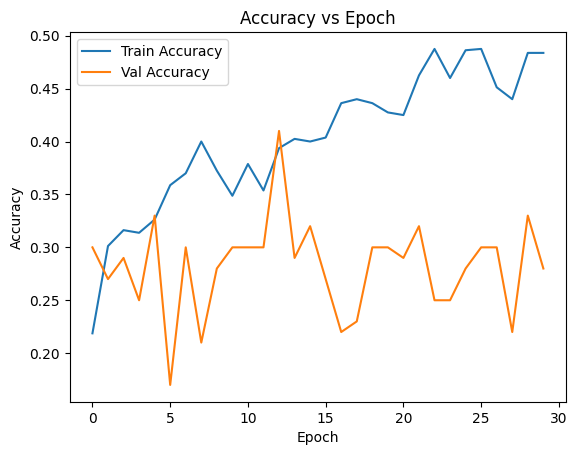

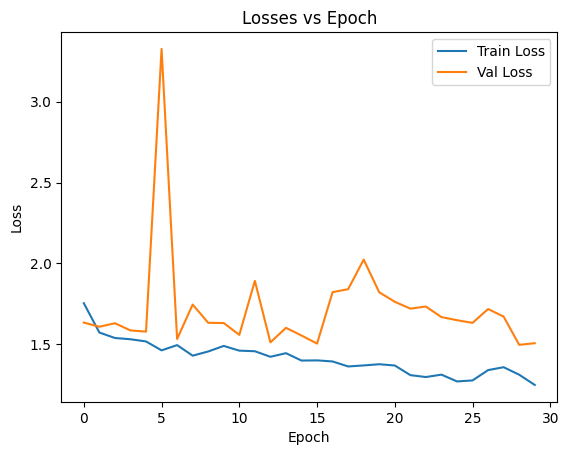

In [ ]:
# HINT: note that your training time should not take more than 2 hours.
# TODO:
# Pick your hyper parameters
from tqdm.auto import tqdm, trange
max_epoch = 30
train_batch = 32
val_batch = 32
test_batch = 32
learning_rate = 1e-3
weight_decay = 1e-3

# Get dataset loaders
data_foldername = 'dataFolder/folder'
train_loader, test_loader, val_loader = get_loaders(data_foldername, train_batch, test_batch, val_batch)

# initialize your network
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")


torch.cuda.empty_cache()

model = models.inception_v3(pretrained=False)

# Move the model to GPU if available
if use_gpu:
    model.cuda()

# Get the number of input features to the fully connected layer
num_features = model.fc.in_features

# Get the number of classes from the dataset
num_classes = get_num_of_classes(data_foldername)

# Replace the fully connected layer with a new one
model.fc = nn.Sequential(
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),  # Add dropout with 20% probability
    nn.Linear(1024, num_classes)
).to(device)
loss_function = nn.CrossEntropyLoss()
# Define the optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)



# Define the training function
def train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path):
    history = {'train_losses': [], 'val_losses': [], 'train_accuracies': [], 'val_accuracies': []}
    best_val_loss = float('inf')

    for epoch in range(max_epoch):
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training
        model.train()
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epoch} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)  # Get final logits
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = correct_train / total_train

        # Validation
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        model.eval()
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{max_epoch} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)  # Get final logits
                loss = loss_function(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct_val / total_val

        # Save best model
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), best_model_path)
            best_val_loss = avg_val_loss

        # Print progress
        print(f"Epoch [{epoch + 1}/{max_epoch}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

        # Store losses and accuracies for plotting
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['train_accuracies'].append(train_accuracy)
        history['val_accuracies'].append(val_accuracy)

    return history

# start training
history = train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path=f'best_model_inception_final.pth')

# Plot losses vs epoch
plot_accuracies(history)

# Plot accuracies vs epoch
plot_losses(history)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Mean Loss: 1.4938
Accuracy: 0.3500
Macro Precision: 0.3216
Macro Recall: 0.3500
Macro F1 Score: 0.3067


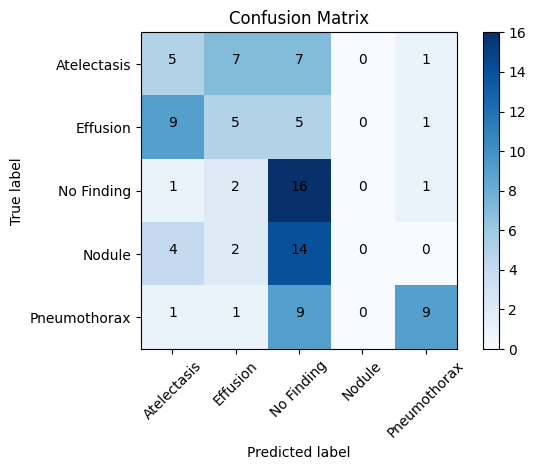

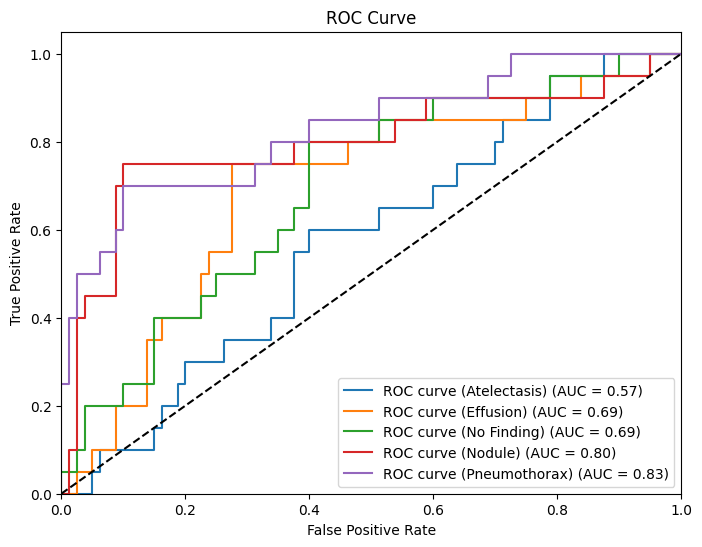

In [ ]:
# Test CNN
# load best model

best_path = os.path.join(os.getcwd(), 'best_model_inception_final.pth')

model = load_best_model_transfer(best_path, data_foldername)

# evaluate on test set
losses, predictions, targets, probs = test_model(model, test_loader, device)
metrics = calculate_metrics(losses, predictions, targets)

# Print metrics
print("Mean Loss: {:.4f}\nAccuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
    metrics['mean_loss'], metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

# plot confusion matrix
conf_matrix = confusion_matrix(targets, predictions)
plot_confusion_matrix(conf_matrix, class_names)

# plot ROC-AUC curves
plot_roc_auc(targets, probs, class_names)